In [131]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from pandas.tseries.offsets import BusinessDay
from calculate_stats import calculate_model_performance_stats

In [110]:
w_ust, w_gld, w_spy = 9038, 4256, 4190
total = w_ust+w_gld+w_spy
print(total)
w_ust, w_gld, w_spy = w_ust/total, w_gld/total, w_spy/total
print(w_ust, w_gld, w_spy)

17484
0.5169297643559826 0.24342255776710134 0.23964767787691604


In [41]:
def prepare_portfolio_df(start, end, tickers, base=1000):
    """
    Prepares a portfolio DataFrame with percentage changes, cumulative returns,
    and portfolio value given tickers, weights, and initial total investment.

    Parameters:
        start (datetime): Start date for data retrieval.
        end (datetime): End date for data retrieval.
        tickers (list): List of stock tickers.
        weights (dict): Dictionary with tickers as keys and weights as values.
        total (float): Initial portfolio value. Default is 1,000,000.

    Returns:
        pd.DataFrame: DataFrame with portfolio value and other metrics.
    """
    if not tickers:
        raise ValueError("Tickers list cannot be empty.")

    if sum(abs(x) for x in tickers.values()) > 1:
        raise ValueError("total of weight > 1")
    
    # Initialize an empty DataFrame
    df = pd.DataFrame(index=pd.bdate_range(start=start, end=end-BusinessDay(1)))

    # Download data and calculate percentage changes
    for ticker in tickers.keys():
        curr = yf.download(ticker, start=start, end=end)
        curr.columns = curr.columns.get_level_values(0)
        # df = pd.concat([df, curr[["Close"]]],axis=1).ffill().bfill()
        curr.rename(columns={"Close": ticker+"_Close"}, inplace=True)
        df = df.merge(curr[[ticker+"_Close"]], left_index=True, right_index=True, how="left").ffill().bfill()

    # print(df.columns)
    for ticker in tickers.keys():
        column_name = ticker+'_Close'
        df[ticker+"_pct_change"] = df[column_name].pct_change().fillna(0)

    # Calculate portfolio percentage change
    df["pf_pct_change"] = sum(
        df[ticker + "_pct_change"] * tickers[ticker] for ticker in tickers.keys()
    )

    # # Calculate cumulative returns and portfolio value
    df["cumulative_returns"] = (1 + df["pf_pct_change"]).cumprod()
    df["pf_val"] = base * df["cumulative_returns"]

    return df

In [42]:
start = "2025-01-01"
end = datetime.date.today()
# end = "2025-01-13"
tickers = {"UTWO": w_ust, "GLD": w_gld, "SPY": w_spy}
# tickers = {"UTWO": 0, "GLD": 0, "SPY": 1}

print(w_ust, w_gld, w_spy, total)
print(sum(abs(x) for x in tickers.values()))

df_curr = prepare_portfolio_df(start, end, tickers, base=1000)
print("annualised vol=",df_curr.pf_pct_change.std()*np.sqrt(365))
print("30-days vol=",df_curr.pf_pct_change.iloc[-30:].std()*np.sqrt(365))
calculate_model_performance_stats(df_curr, "pf_val", base=1000)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

0.5169297643559826 0.24342255776710134 0.23964767787691604 17484
1.0
annualised vol= 0.025751840948187388
30-days vol= 0.025751840948187388


{'pf_val': 1000.2701189834033,
 'pf_val_returns': 0.0002701189834033446,
 'pf_val_sharpe': -1.1501616286806005,
 'pf_val_mdd': 0.002085321949353999}

0.5000137858342275


,UTWO_Close,GLD_Close,SPY_Close,UTWO_pct_change,GLD_pct_change,SPY_pct_change,pf_pct_change,cumulative_returns,pf_val
2025-01-01,48.049999,245.419998,584.640015,0.000000,0.000000,0.000000,0.000000,1.000000,1000.000000
2025-01-02,48.049999,245.419998,584.640015,0.000000,0.000000,0.000000,0.000000,1.000000,1000.000000
2025-01-03,48.025002,243.490005,591.950012,-0.000520,-0.007864,0.012503,0.000813,1.000813,1000.813201
2025-01-06,48.044998,243.190002,595.359985,0.000416,-0.001232,0.005761,0.001296,1.002110,1002.110082
2025-01-07,48.020000,244.559998,588.630005,-0.000520,0.005633,-0.011304,-0.001607,1.000500,1000.500050
2025-01-08,48.040001,245.860001,589.489990,0.000417,0.005316,0.001461,0.001859,1.002360,1002.360363
2025-01-09,48.040001,245.860001,589.489990,0.000000,0.000000,0.000000,0.000000,1.002360,1002.360363
2025-01-10,47.970001,248.210007,580.489990,-0.001457,0.009558,-0.015267,-0.002085,1.000270,1000.270119


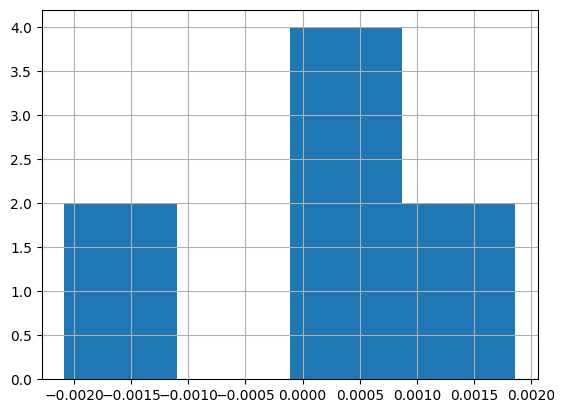

In [43]:
plt.hist(df_curr.pf_pct_change, bins="auto")
plt.grid(True)
print(1-norm.cdf(0,df_curr.pf_pct_change.mean()))
df_curr["pf_pct_change"].describe()
df_curr

In [54]:
start = "2025-01-01"
end = datetime.date.today()
# end = "2009-01-01"
tickers = {"UUP": 0.25, "JPY=X": 0, "IBIT": .05, "XLU": 0.0, "XLF": 0.0, "XLC":0.0, "XLY":0, "GLD": .20, "SPY": .25, "SHY": .25, "USDCNY=X": 0}

df = prepare_portfolio_df(start, end, tickers, base=1000)

print(sum(abs(x) for x in tickers.values()))
print([{ticker:abs(weight)*17830} for ticker, weight in tickers.items()])

print("annualised vol=",df.pf_pct_change.std()*np.sqrt(365))
print("30-days vol=",df.pf_pct_change.iloc[-30:].std()*np.sqrt(365))
calculate_model_performance_stats(df, "pf_val")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1.0
[{'UUP': 4457.5}, {'JPY=X': 0}, {'IBIT': 891.5}, {'XLU': 0.0}, {'XLF': 0.0}, {'XLC': 0.0}, {'XLY': 0}, {'GLD': 3566.0}, {'SPY': 4457.5}, {'SHY': 4457.5}, {'USDCNY=X': 0}]
annualised vol= 0.03193611466254119
30-days vol= 0.03193611466254119


{'pf_val': 998.3208889367813,
 'pf_val_returns': -0.001679111063218719,
 'pf_val_sharpe': -3.599567698693228,
 'pf_val_mdd': 0.0046186571857167865}

In [47]:
df.tail()

,UUP_Close,JPY=X_Close,IBIT_Close,XLU_Close,XLF_Close,XLC_Close,XLY_Close,GLD_Close,SPY_Close,SHY_Close,...,XLF_pct_change,XLC_pct_change,XLY_pct_change,GLD_pct_change,SPY_pct_change,SHY_pct_change,USDCNY=X_pct_change,pf_pct_change,cumulative_returns,pf_val
2025-01-06,29.389999,157.481003,58.169998,76.220001,48.439999,98.940002,226.770004,243.190002,595.359985,81.980003,...,-0.003087,0.010830,0.003940,-0.001232,0.005761,0.000244,0.002877,0.001624,1.002953,1002.953186
2025-01-07,29.500000,157.742996,54.790001,76.029999,48.330002,97.839996,222.380005,244.559998,588.630005,81.930000,...,-0.002271,-0.011118,-0.019359,0.005633,-0.011304,-0.000610,0.000369,-0.003821,0.999121,999.120511
2025-01-08,29.610001,158.235992,53.340000,76.010002,48.490002,97.260002,223.009995,245.860001,589.489990,81.980003,...,0.003311,-0.005928,0.002833,0.005316,0.001461,0.000610,0.000560,0.001190,1.000309,1000.309402
2025-01-09,29.610001,158.192001,53.340000,76.010002,48.490002,97.260002,223.009995,245.860001,589.489990,81.980003,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000696,0.000000,1.000309,1000.309402
2025-01-10,29.760000,158.048004,53.840000,75.580002,47.320000,95.809998,220.820007,248.210007,580.489990,81.830002,...,-0.024129,-0.014909,-0.009820,0.009558,-0.015267,-0.001830,0.000082,-0.000627,0.999682,999.681730


Index(['UUP_Close', 'JPY=X_Close', 'IBIT_Close', 'XLU_Close', 'XLF_Close',
       'XLC_Close', 'XLY_Close', 'GLD_Close', 'SPY_Close', 'SHY_Close',
       'USDCNY=X_Close', 'UUP_pct_change', 'JPY=X_pct_change',
       'IBIT_pct_change', 'XLU_pct_change', 'XLF_pct_change', 'XLC_pct_change',
       'XLY_pct_change', 'GLD_pct_change', 'SPY_pct_change', 'SHY_pct_change',
       'USDCNY=X_pct_change', 'pf_pct_change', 'cumulative_returns', 'pf_val'],
      dtype='object')
0.4999846457505237


count    8.000000
mean    -0.000038
std      0.001724
min     -0.003821
25%     -0.000157
50%      0.000000
75%      0.001224
max      0.001624
Name: pf_pct_change, dtype: float64

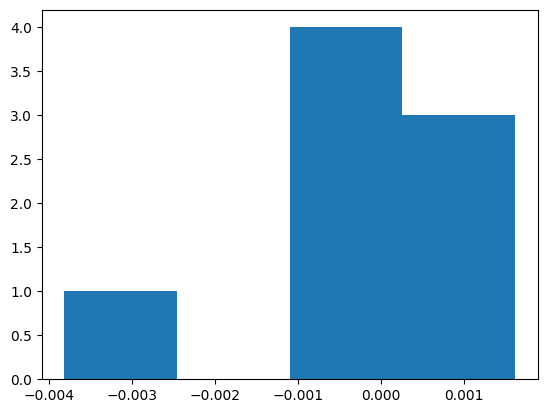

In [48]:
print(df.columns)
x = 'pf_pct_change'
plt.hist(df[x], bins="auto")
print(1-norm.cdf(0,df[x].mean()))
df[x].describe()

In [49]:
tickers_corr = df[[x+"_pct_change" for x in tickers]]
tickers_corr.corr()

,UUP_pct_change,JPY=X_pct_change,IBIT_pct_change,XLU_pct_change,XLF_pct_change,XLC_pct_change,XLY_pct_change,GLD_pct_change,SPY_pct_change,SHY_pct_change,USDCNY=X_pct_change
UUP_pct_change,1.000000,0.330970,-0.708156,0.023772,-0.454111,-0.969787,-0.647828,0.816890,-0.786515,-0.515087,-0.641046
JPY=X_pct_change,0.330970,1.000000,-0.536709,-0.426342,0.121637,-0.260354,-0.437237,0.513166,-0.223159,0.373849,0.263345
IBIT_pct_change,-0.708156,-0.536709,1.000000,-0.207579,-0.145664,0.648545,0.579615,-0.444452,0.458945,0.045826,0.482278
XLU_pct_change,0.023772,-0.426342,-0.207579,1.000000,0.585139,0.113099,0.554409,-0.551153,0.459367,0.225985,-0.665765
XLF_pct_change,-0.454111,0.121637,-0.145664,0.585139,1.000000,0.612868,0.574277,-0.730521,0.791830,0.879368,0.020923
XLC_pct_change,-0.969787,-0.260354,0.648545,0.113099,0.612868,1.000000,0.749894,-0.872612,0.894078,0.681928,0.549654
XLY_pct_change,-0.647828,-0.437237,0.579615,0.554409,0.574277,0.749894,1.000000,-0.823585,0.920194,0.544012,0.099396
GLD_pct_change,0.816890,0.513166,-0.444452,-0.551153,-0.730521,-0.872612,-0.823585,1.000000,-0.903272,-0.569650,-0.135803
SPY_pct_change,-0.786515,-0.223159,0.458945,0.459367,0.791830,0.894078,0.920194,-0.903272,1.000000,0.780952,0.281645
SHY_pct_change,-0.515087,0.373849,0.045826,0.225985,0.879368,0.681928,0.544012,-0.569650,0.780952,1.000000,0.318142


In [50]:
def solve(df, capital, ticker):
    df[ticker+"_cumulative_returns"] = (1+df[ticker+"_pct_change"]).cumprod()
    df[ticker+"_val"] = capital*df[ticker+"_cumulative_returns"]
    return df

for i in [x for x in tickers]:
    df = solve(df,1000, i)

df.tail()

,UUP_Close,JPY=X_Close,IBIT_Close,XLU_Close,XLF_Close,XLC_Close,XLY_Close,GLD_Close,SPY_Close,SHY_Close,...,XLY_cumulative_returns,XLY_val,GLD_cumulative_returns,GLD_val,SPY_cumulative_returns,SPY_val,SHY_cumulative_returns,SHY_val,USDCNY=X_cumulative_returns,USDCNY=X_val
2025-01-06,29.389999,157.481003,58.169998,76.220001,48.439999,98.940002,226.770004,243.190002,595.359985,81.980003,...,1.024255,1024.254790,0.990914,990.913553,1.018336,1018.336019,1.000244,1000.244074,1.002946,1002.945987
2025-01-07,29.500000,157.742996,54.790001,76.029999,48.330002,97.839996,222.380005,244.559998,588.630005,81.930000,...,1.004426,1004.426427,0.996496,996.495801,1.006825,1006.824696,0.999634,999.633983,1.003316,1003.315926
2025-01-08,29.610001,158.235992,53.340000,76.010002,48.490002,97.260002,223.009995,245.860001,589.489990,81.980003,...,1.007272,1007.271909,1.001793,1001.792855,1.008296,1008.295661,1.000244,1000.244074,1.003878,1003.877695
2025-01-09,29.610001,158.192001,53.340000,76.010002,48.490002,97.260002,223.009995,245.860001,589.489990,81.980003,...,1.007272,1007.271909,1.001793,1001.792855,1.008296,1008.295661,1.000244,1000.244074,1.004577,1004.576542
2025-01-10,29.760000,158.048004,53.840000,75.580002,47.320000,95.809998,220.820007,248.210007,580.489990,81.830002,...,0.997380,997.380368,1.011368,1011.368302,0.992902,992.901573,0.998414,998.413894,1.004659,1004.658736


UUP annualised vol 0.0732313677618246
{'UUP_val': 1003.0333721724456, 'UUP_val_returns': 0.003033372172445592, 'UUP_val_sharpe': 1.44557155824495, 'UUP_val_mdd': 0.009437165012656238}
UUP daily change = 0.005065843142125326
UUP WoW change = 0.003033372172445592
JPY=X annualised vol 0.031133021909877757
{'JPY=X_val': 1002.0860519150425, 'JPY=X_val_returns': 0.0020860519150425194, 'JPY=X_val_sharpe': 1.8702490121302666, 'JPY=X_val_mdd': 0.0022634853262375144}
JPY=X daily change = -0.000910268478561016
JPY=X WoW change = 0.0020860519150425194
IBIT annualised vol 0.5480006836777679
{'IBIT_val': 972.3677296584553, 'IBIT_val_returns': -0.027632270341544696, 'IBIT_val_sharpe': -2.287178855438096, 'IBIT_val_mdd': 0.08303245948761223}
IBIT daily change = 0.009373828244650717
IBIT WoW change = -0.027632270341544696
XLU annualised vol 0.11767073296692293
{'XLU_val': 990.9532602283857, 'XLU_val_returns': -0.009046739771614298, 'XLU_val_sharpe': -4.04766198028946, 'XLU_val_mdd': 0.01946030052370421

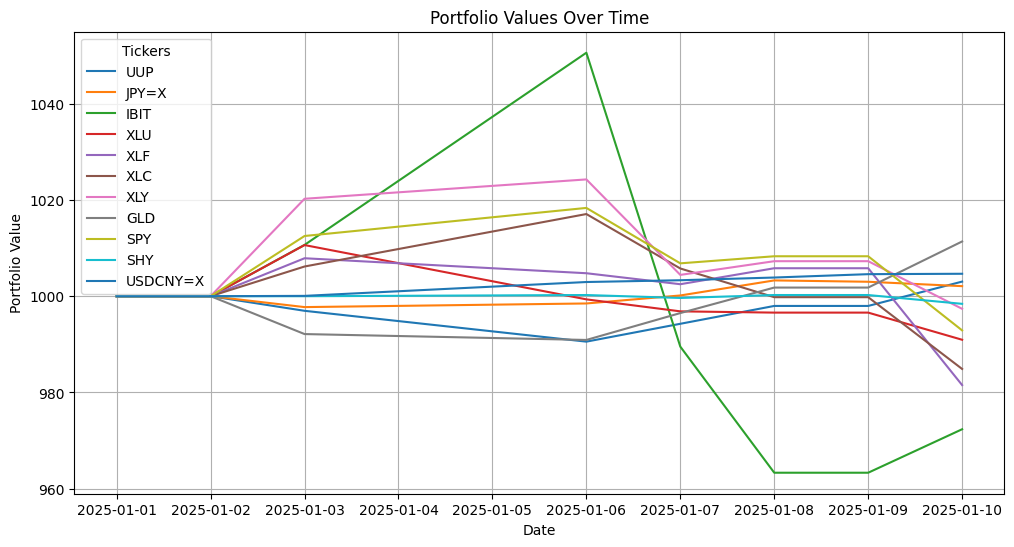

In [51]:
plt.figure(figsize=(12, 6))

# Loop through each ticker to calculate stats and plot
for i in tickers:
    print(i+" annualised vol", df[i+"_pct_change"].std() * np.sqrt(365))
    print(calculate_model_performance_stats(df, i+"_val"))
    print(i+" daily change =", df[i+"_pct_change"].iloc[-1])
    print(i+" WoW change =", df[i+"_val"].iloc[-1]/df[i+"_val"].iloc[-8]-1)
    # Plot the values
    plt.plot(df.index, df[i+"_val"], label=i)

# Add grid, legend, and labels
plt.grid(True)
plt.legend(title="Tickers")
plt.title("Portfolio Values Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.show()

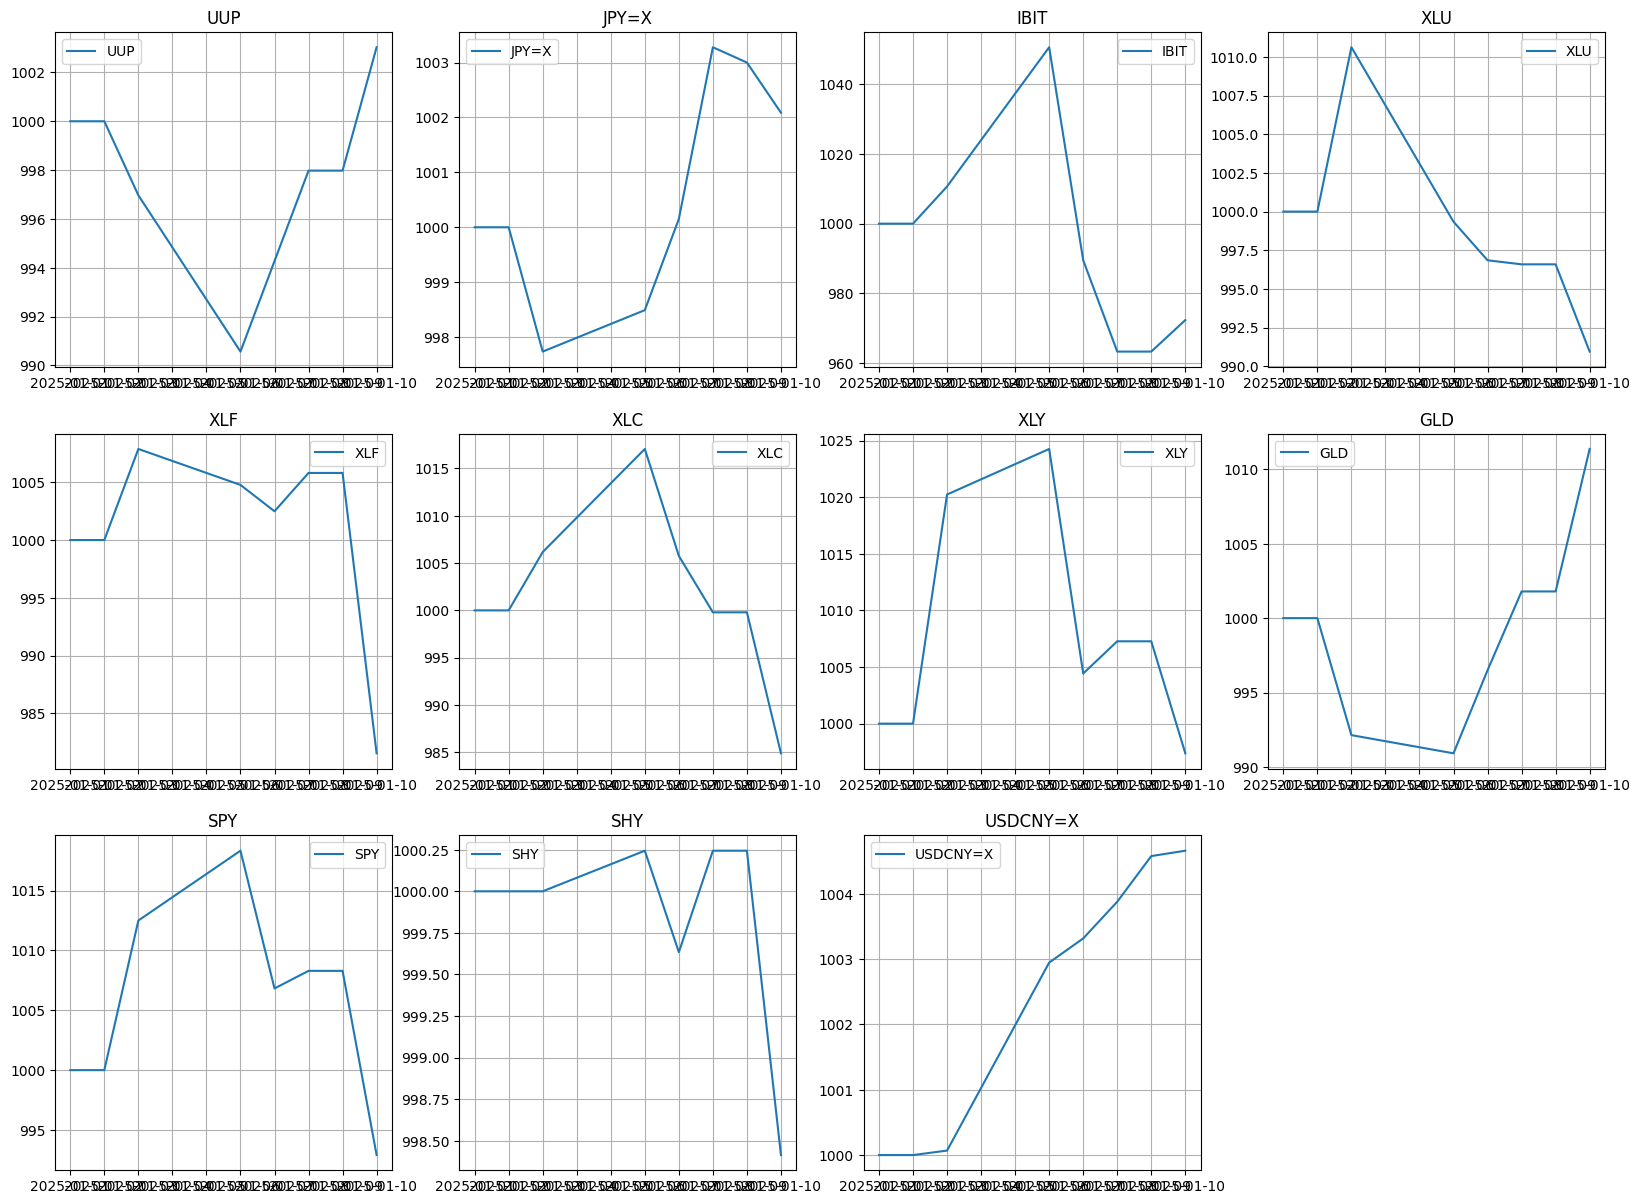

In [52]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))  # 3x3 grid

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through tickers and plot
for idx, ticker in enumerate(tickers):
    ax = axes[idx]  # Select subplot axis
    ax.plot(df.index, df[ticker + "_val"], label=ticker)
    ax.set_title(ticker)
    ax.legend()
    ax.grid()

# Remove unused subplots if tickers < 9
for idx in range(len(tickers), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
# plt.tight_layout()
plt.show()